In [60]:
from pathlib import Path
import re

def process_images(dir_path, output_file):
    """
    Processes images in the given directory to extract actual ages from filenames
    and saves the annotations in the output file.

    Args:
    - dir_path (str): Path to the directory containing images.
    - output_file (str): Path to save the annotation file.

    Returns:
    - images_list (list): List of image paths.
    - labels_list (list): List of corresponding labels (ages).
    """
    labels_list = []
    images_list = []
    dir_path = Path(dir_path)

    for img_path in dir_path.glob('*.JPG'):  # Look for .JPG files in the directory
        images_list.append(str(img_path))
        try:
            # Extract the actual age using a regular expression to handle cases like '07a', '10b'
            filename = img_path.stem  # Get filename without extension
            match = re.search(r'A(\d+)', filename)  # Look for 'A' followed by digits
            if match:
                label = int(match.group(1))  # Extract numeric part after 'A'
                labels_list.append(label)
            else:
                raise ValueError(f"No valid age found in {filename}")
        except (ValueError, IndexError) as e:
            print(f"Error processing {img_path}: {e}")
            continue

    # Save annotations (image_path label) to the output file
    with open(output_file, 'w') as f:
        for img, label in zip(images_list, labels_list):
            f.write(f"{img} {label}\n")

    print(f"Annotations saved to {output_file}")
    return images_list, labels_list



In [61]:
dir_path = "/kaggle/input/fgnet-dataset/FGNET/images"
output_file = "/kaggle/working/annotations.txt"
images_list, labels_list = process_images(dir_path, output_file)

# Print results
print("Images:", images_list[:5])  # Show first 5 image paths
print("Labels:", labels_list[:5])  # Show first 5 labels

Annotations saved to /kaggle/working/annotations.txt
Images: ['/kaggle/input/fgnet-dataset/FGNET/images/019A30.JPG', '/kaggle/input/fgnet-dataset/FGNET/images/036A00.JPG', '/kaggle/input/fgnet-dataset/FGNET/images/015A03.JPG', '/kaggle/input/fgnet-dataset/FGNET/images/060A17.JPG', '/kaggle/input/fgnet-dataset/FGNET/images/033A14.JPG']
Labels: [30, 0, 3, 17, 14]


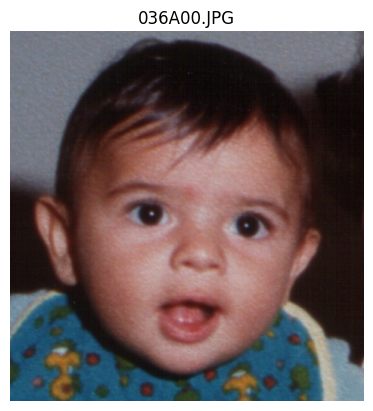

In [46]:
from PIL import Image
import matplotlib.pyplot as plt

# Path to the image
image_path = "/kaggle/input/fgnet-dataset/FGNET/images/036A00.JPG"

# Load and display the image
image = Image.open(image_path)
plt.imshow(image)
plt.axis("off")
plt.title("036A00.JPG")
plt.show()


In [5]:
!pip install torch-geometric

In [62]:
import os
import math
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error

import torch
import torch.nn.functional as F

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models

try:
    from torch_geometric.data import Data as GeometricData
    from torch_geometric.nn import MessagePassing
except ImportError:
    raise ImportError("Please install PyTorch Geometric: pip install torch-geometric")

In [63]:
###############################################################################
# Dataset Class
###############################################################################
class CustomAgeDataset(Dataset):
    def __init__(self, img_dir, annotations, transform=None):
        self.img_dir = img_dir
        self.annotations = annotations
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path, age_label = self.annotations[idx]
        img = Image.open(os.path.join(self.img_dir, img_path)).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, age_label

In [64]:
def load_dataset(img_dir, annotation_file):
    annotations = []
    with open(annotation_file, 'r') as f:
        for line in f:
            name, age = line.strip().split()
            annotations.append((name, float(age)))

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    return CustomAgeDataset(img_dir, annotations, transform)

In [65]:
###############################################################################
# Graph Construction
###############################################################################
def image_to_patches(img_tensor, patch_size=16):
    C, H, W = img_tensor.shape
    patches = []
    coords = []
    h_patches = H // patch_size
    w_patches = W // patch_size
    for i in range(h_patches):
        for j in range(w_patches):
            patch = img_tensor[:, i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size]
            patches.append(patch)
            coords.append((i, j))
    return patches, coords

def build_graph_from_image_features(patches):
    x = torch.stack(patches, dim=0) if isinstance(patches, list) else patches
    N = x.size(0)
    h_patches = int(math.sqrt(N))
    edges = []
    for i in range(h_patches):
        for j in range(h_patches):
            idx = i * h_patches + j
            if j + 1 < h_patches:
                edges.append((idx, idx + 1))
            if i + 1 < h_patches:
                edges.append((idx, idx + h_patches))
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    return GeometricData(x=x, edge_index=edge_index)


In [66]:
class PatchFeatureExtractor(nn.Module):
    def __init__(self):
        super(PatchFeatureExtractor, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

    def forward(self, patch):
        feat = self.conv(patch)
        return feat.view(feat.size(0), -1)

In [67]:
class MaxRelativeGraphConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(MaxRelativeGraphConv, self).__init__(aggr='mean')
        self.lin = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.lin(x)
        return self.propagate(edge_index, x=x)

    def message(self, x_j):
        return x_j

    def update(self, aggr_out):
        return torch.relu(aggr_out)

In [69]:

class GCNEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(GCNEncoder, self).__init__()
        self.conv1 = MaxRelativeGraphConv(in_dim, hidden_dim)
        self.conv2 = MaxRelativeGraphConv(hidden_dim, out_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        return x


In [70]:
class AnchorEncoder(nn.Module):
    def __init__(self, output_dim=128):
        super(AnchorEncoder, self).__init__()
        base_model = models.resnet18(pretrained=True)
        base_model.fc = nn.Identity()
        self.base = base_model
        self.mlp = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, output_dim)
        )

    def forward(self, img):
        return self.mlp(self.base(img))

In [71]:
class RegressionHead(nn.Module):
    def __init__(self, input_dim=128):
        super(RegressionHead, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)

In [72]:

###############################################################################
# Training and Evaluation
###############################################################################
def train_epoch(model_anchor, model_patch, patch_extractor, regression_head, optimizer, dataloader, device):
    model_anchor.train()
    model_patch.train()
    patch_extractor.train()
    regression_head.train()
    total_loss = 0.0

    for img, age in dataloader:
        img = img.to(device)
        age = age.to(device).float().unsqueeze(1)  # Explicitly cast to Float

        # Get anchor embeddings
        anchor = model_anchor(img)  # Shape: [B, 128]
        predicted_age = regression_head(anchor)  # Shape: [B, 1]

        # Compute regression loss
        loss = F.mse_loss(predicted_age, age)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * img.size(0)

    return total_loss / len(dataloader.dataset)


def evaluate(model_anchor, regression_head, dataloader, device):
    model_anchor.eval()
    regression_head.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for img, age in dataloader:
            img = img.to(device)
            age = age.float().cpu().numpy()  # Convert to Float before converting to NumPy

            # Predict ages
            anchor = model_anchor(img)  # Shape: [B, 128]
            predicted_age = regression_head(anchor).squeeze(1).cpu().numpy()  # Shape: [B]

            all_preds.extend(predicted_age)
            all_labels.extend(age)

    mae = mean_absolute_error(all_labels, all_preds)
    return mae

In [48]:
###############################################################################
# Main
###############################################################################
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img_dir = "/kaggle/input/fgnet-dataset/FGNET/images"
    annotation_file = "/kaggle/working/annotations.txt"
    dataset = load_dataset(img_dir, annotation_file)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_data, val_data = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=8, shuffle=False)

    model_anchor = AnchorEncoder(output_dim=128).to(device)
    patch_extractor = PatchFeatureExtractor().to(device)
    model_patch = GCNEncoder(in_dim=64, hidden_dim=128, out_dim=128).to(device)
    regression_head = RegressionHead(input_dim=128).to(device)

    optimizer = optim.Adam(
        list(model_anchor.parameters()) + 
        list(patch_extractor.parameters()) + 
        list(model_patch.parameters()) + 
        list(regression_head.parameters()),
        lr=1e-4
    )

    for epoch in range(60):
        train_loss = train_epoch(model_anchor, model_patch, patch_extractor, regression_head, optimizer, train_loader, device)
        val_mae = evaluate(model_anchor, regression_head, val_loader, device)
        print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Val MAE = {val_mae:.4f}")


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Loss = 173.1256, Val MAE = 5.8184
Epoch 2: Train Loss = 49.2279, Val MAE = 4.9081
Epoch 3: Train Loss = 41.5996, Val MAE = 4.6597
Epoch 4: Train Loss = 41.5435, Val MAE = 5.7241
Epoch 5: Train Loss = 35.5865, Val MAE = 4.9816
Epoch 6: Train Loss = 32.6018, Val MAE = 4.9005
Epoch 7: Train Loss = 26.7866, Val MAE = 4.2457
Epoch 8: Train Loss = 25.8998, Val MAE = 4.4440
Epoch 9: Train Loss = 22.4042, Val MAE = 4.3293
Epoch 10: Train Loss = 24.2285, Val MAE = 4.1771
Epoch 11: Train Loss = 28.4901, Val MAE = 4.2781
Epoch 12: Train Loss = 22.8342, Val MAE = 4.6677
Epoch 13: Train Loss = 20.3219, Val MAE = 4.1287
Epoch 14: Train Loss = 17.2725, Val MAE = 4.8285
Epoch 15: Train Loss = 13.7369, Val MAE = 3.9291
Epoch 16: Train Loss = 12.9428, Val MAE = 4.2887
Epoch 17: Train Loss = 15.7321, Val MAE = 4.5238
Epoch 18: Train Loss = 13.8925, Val MAE = 3.9532
Epoch 19: Train Loss = 12.9164, Val MAE = 5.1005
Epoch 20: Train Loss = 12.6043, Val MAE = 4.7349
Epoch 21: Train Loss = 10.72

In [49]:
import matplotlib.pyplot as plt
import numpy as np

def plot_performance_metrics(model_anchor, regression_head, dataloader, device):
    """
    Plot performance metrics for the model.
    Includes scatter plot and error distribution histogram.

    Args:
        model_anchor (nn.Module): Trained anchor model.
        regression_head (nn.Module): Regression head for age prediction.
        dataloader (DataLoader): DataLoader for the evaluation dataset.
        device (torch.device): Device to run the evaluation.

    Returns:
        None
    """
    model_anchor.eval()
    regression_head.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for img, age in dataloader:
            img = img.to(device)
            age = age.cpu().numpy()

            # Predict ages
            anchor = model_anchor(img)
            predicted_age = regression_head(anchor).squeeze(1).cpu().numpy()

            all_preds.extend(predicted_age)
            all_labels.extend(age)

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Scatter plot: True vs. Predicted Ages
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(all_labels, all_preds, alpha=0.6)
    plt.plot([all_labels.min(), all_labels.max()], [all_labels.min(), all_labels.max()], 'r--', label='Ideal Fit')
    plt.xlabel('True Age')
    plt.ylabel('Predicted Age')
    plt.title('True vs. Predicted Ages')
    plt.legend()
    plt.grid(True)

    # Error distribution histogram
    errors = all_preds - all_labels
    plt.subplot(1, 2, 2)
    plt.hist(errors, bins=20, color='blue', alpha=0.7, edgecolor='black')
    plt.axvline(0, color='red', linestyle='dashed', linewidth=1, label='Zero Error')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title('Error Distribution')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


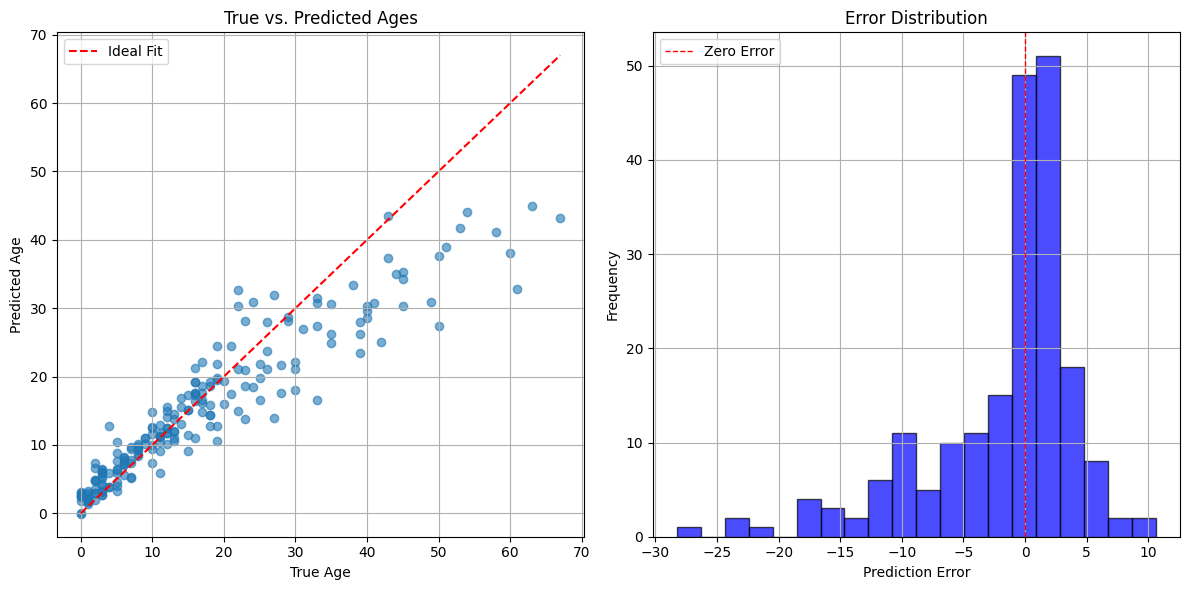

In [50]:
# Visualize model performance on the validation set
plot_performance_metrics(model_anchor, regression_head, val_loader, device)


In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model_performance(model_anchor, regression_head, dataloader, device):
    """
    Evaluate the model's performance using MAE, RMSE, and R² metrics.

    Args:
        model_anchor (nn.Module): Trained anchor model.
        regression_head (nn.Module): Regression head for age prediction.
        dataloader (DataLoader): DataLoader for the evaluation dataset.
        device (torch.device): Device to run the evaluation.

    Returns:
        dict: Dictionary containing MAE, RMSE, and R² metrics.
    """
    model_anchor.eval()
    regression_head.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for img, age in dataloader:
            img = img.to(device)
            age = age.to(device).cpu().numpy()

            # Predict ages
            anchor = model_anchor(img)  # Shape: [B, 128]
            predicted_age = regression_head(anchor).squeeze(1).cpu().numpy()  # Shape: [B]

            all_preds.extend(predicted_age)
            all_labels.extend(age)

    # Compute metrics
    mae = mean_absolute_error(all_labels, all_preds)
    rmse = np.sqrt(mean_squared_error(all_labels, all_preds))
    r2 = r2_score(all_labels, all_preds)

    return {"MAE": mae, "RMSE": rmse, "R2": r2}


In [52]:
# Evaluate model on validation set
metrics = evaluate_model_performance(model_anchor, regression_head, val_loader, device)

print(f"Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {metrics['MAE']:.2f}")
print(f"Root Mean Squared Error (RMSE): {metrics['RMSE']:.2f}")
print(f"R² Score: {metrics['R2']:.2f}")


Evaluation Metrics:
Mean Absolute Error (MAE): 4.17
Root Mean Squared Error (RMSE): 6.44
R² Score: 0.81


In [53]:
from torchvision import transforms
from PIL import Image
import torch

def predict_random_images(model_anchor, regression_head, image_paths, transform, device):
    """
    Predict the age for a list of image paths.

    Args:
        model_anchor (nn.Module): Trained anchor model.
        regression_head (nn.Module): Regression head for age prediction.
        image_paths (list): List of paths to the images.
        transform (callable): Transformations to apply to the images.
        device (torch.device): Device to run the predictions.

    Returns:
        dict: Dictionary with image paths as keys and predicted ages as values.
    """
    model_anchor.eval()
    regression_head.eval()

    predictions = {}
    with torch.no_grad():
        for image_path in image_paths:
            # Open and transform the image
            img = Image.open(image_path).convert("RGB")
            img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension
            
            # Get anchor embedding and predict age
            anchor = model_anchor(img_tensor)
            predicted_age = regression_head(anchor).item()
            
            predictions[image_path] = predicted_age

    return predictions

# Transform for preprocessing images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Define a list of random image paths
random_image_paths = [
      "/kaggle/input/fgnet-dataset/FGNET/images/001A10.JPG",
    "/kaggle/input/fgnet-dataset/FGNET/images/001A16.JPG",
    "/kaggle/input/fgnet-dataset/FGNET/images/001A19.JPG"
]

# Use the models directly after training
# Assuming `model_anchor`, `regression_head` have been trained and are available in the current context

predictions = predict_random_images(model_anchor, regression_head, random_image_paths, transform, device)

# Print predictions
for img_path, age in predictions.items():
    print(f"Predicted age for {img_path}: {age:.2f} years")


Predicted age for /kaggle/input/fgnet-dataset/FGNET/images/001A10.JPG: 9.80 years
Predicted age for /kaggle/input/fgnet-dataset/FGNET/images/001A16.JPG: 14.46 years
Predicted age for /kaggle/input/fgnet-dataset/FGNET/images/001A19.JPG: 21.81 years


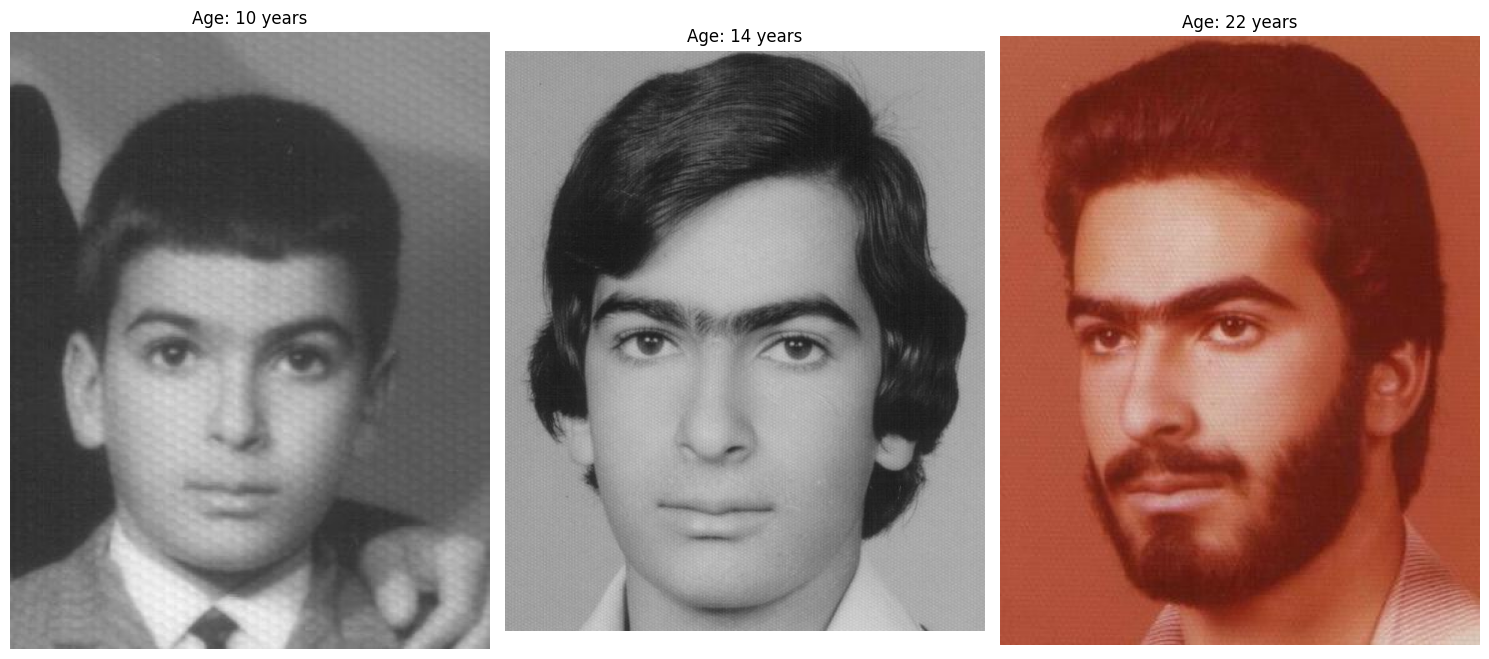

In [54]:
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torch

def predict_and_display_images(model_anchor, regression_head, image_paths, transform, device):
    """
    Predict the age for a list of image paths and display the images with predictions.

    Args:
        model_anchor (nn.Module): Trained anchor model.
        regression_head (nn.Module): Regression head for age prediction.
        image_paths (list): List of paths to the images.
        transform (callable): Transformations to apply to the images.
        device (torch.device): Device to run the predictions.
    """
    model_anchor.eval()
    regression_head.eval()

    predictions = []
    images = []
    
    with torch.no_grad():
        for image_path in image_paths:
            # Open and transform the image
            img = Image.open(image_path).convert("RGB")
            img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension
            
            # Get anchor embedding and predict age
            anchor = model_anchor(img_tensor)
            predicted_age = regression_head(anchor).item()
            rounded_age = int(round(predicted_age))  # Round to nearest integer
            
            predictions.append((image_path, rounded_age))
            images.append(img)
    
    # Display images and predictions
    plt.figure(figsize=(15, 10))
    for i, (img, (path, age)) in enumerate(zip(images, predictions)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        plt.title(f"Age: {age} years")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Define the transform (same as used for training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Define a list of random image paths
random_image_paths = [
    "/kaggle/input/fgnet-dataset/FGNET/images/001A10.JPG",
    "/kaggle/input/fgnet-dataset/FGNET/images/001A16.JPG",
    "/kaggle/input/fgnet-dataset/FGNET/images/001A19.JPG"
]

# Use the models directly after training
# Assuming `model_anchor`, `regression_head` have been trained and are available in the current context

predict_and_display_images(model_anchor, regression_head, random_image_paths, transform, device)


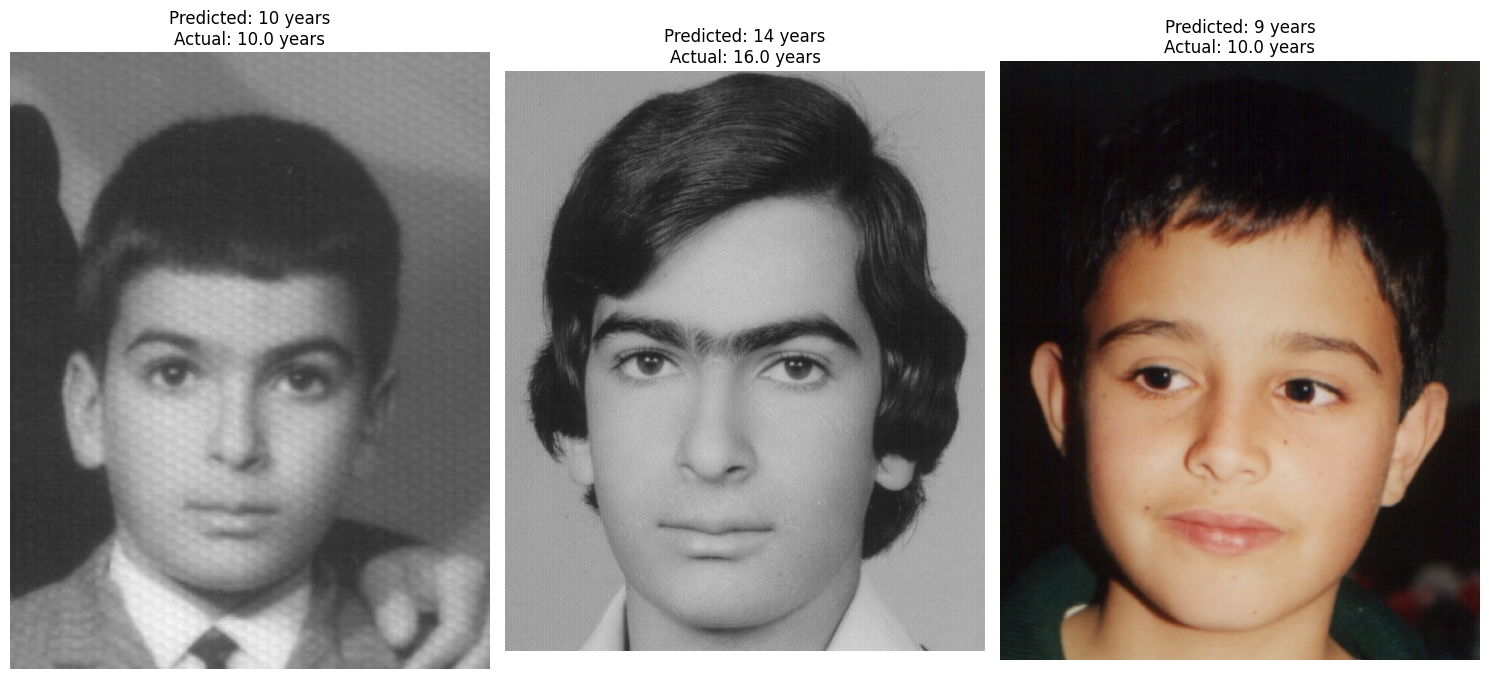

In [55]:
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torch



def predict_and_display_images_with_labels(model_anchor, regression_head, image_paths, annotations, transform, device):
    """
    Predict the age for a list of image paths and display the images with predictions and actual labels.

    Args:
        model_anchor (nn.Module): Trained anchor model.
        regression_head (nn.Module): Regression head for age prediction.
        image_paths (list): List of paths to the images.
        annotations (dict): Dictionary mapping image paths to actual age labels.
        transform (callable): Transformations to apply to the images.
        device (torch.device): Device to run the predictions.
    """
    model_anchor.eval()
    regression_head.eval()

    predictions = []
    actual_labels = []
    images = []
    
    with torch.no_grad():
        for image_path in image_paths:
            # Open and transform the image
            img = Image.open(image_path).convert("RGB")
            img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension
            
            # Get anchor embedding and predict age
            anchor = model_anchor(img_tensor)
            predicted_age = regression_head(anchor).item()
            rounded_age = int(round(predicted_age))  # Round to nearest integer
            
            # Append results
            predictions.append(rounded_age)
            actual_labels.append(annotations[image_path])  # Fetch actual label dynamically
            images.append(img)
    
    # Display images, predictions, and actual labels
    plt.figure(figsize=(15, 10))
    for i, (img, predicted_age, actual_label) in enumerate(zip(images, predictions, actual_labels)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_age} years\nActual: {actual_label} years")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Define the transform (same as used for training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load annotations dynamically from the dataset
dataset_annotations = {
    os.path.join("/kaggle/input/fgnet-dataset/FGNET/images", name): age
    for name, age in load_dataset("/kaggle/input/fgnet-dataset/FGNET/images", "/kaggle/working/annotations.txt").annotations
}

# Define a list of random image paths
random_image_paths = [
    "/kaggle/input/fgnet-dataset/FGNET/images/001A10.JPG",
    "/kaggle/input/fgnet-dataset/FGNET/images/001A16.JPG",
    "/kaggle/input/fgnet-dataset/FGNET/images/080A10.JPG"
]

# Use the models directly after training
predict_and_display_images_with_labels(
    model_anchor, regression_head, random_image_paths, dataset_annotations, transform, device
)


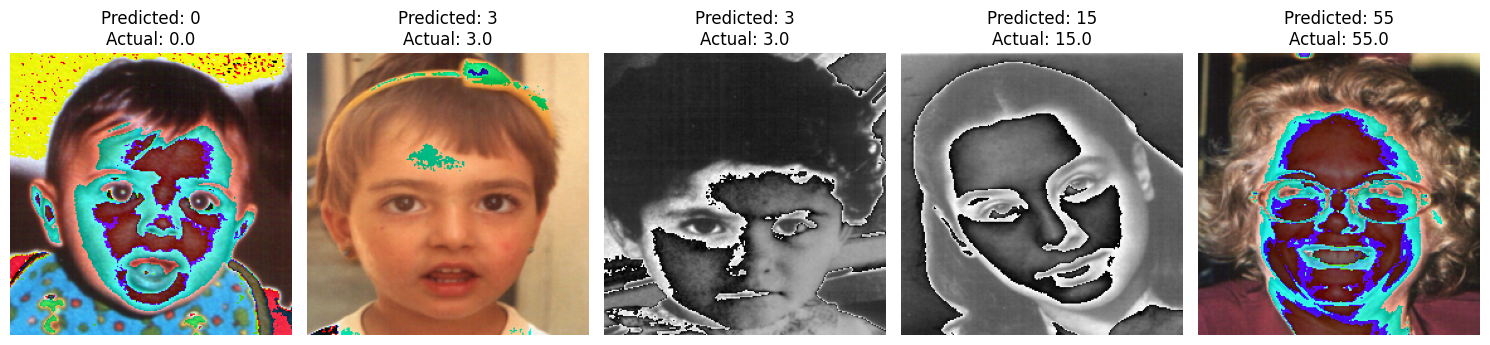

In [56]:
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torch
from torch.utils.data import DataLoader

def display_correct_images_limited(model_anchor, regression_head, dataloader, device, max_images=5):
    """
    Display up to `max_images` images where the predicted age matches the actual age.

    Args:
        model_anchor (nn.Module): Trained anchor model.
        regression_head (nn.Module): Regression head for age prediction.
        dataloader (DataLoader): DataLoader for the evaluation dataset.
        device (torch.device): Device to run the predictions.
        max_images (int): Maximum number of correct images to display.

    Returns:
        None
    """
    model_anchor.eval()
    regression_head.eval()

    correct_images = []

    with torch.no_grad():
        for img_batch, actual_labels in dataloader:
            img_batch = img_batch.to(device)
            actual_labels = actual_labels.cpu().numpy()

            # Predict ages
            anchor_embeddings = model_anchor(img_batch)
            predicted_ages = regression_head(anchor_embeddings).squeeze(1).cpu().numpy()
            rounded_predictions = [int(round(age)) for age in predicted_ages]

            # Check correct predictions
            for idx, (predicted, actual) in enumerate(zip(rounded_predictions, actual_labels)):
                if predicted == actual:
                    correct_images.append((img_batch[idx].cpu(), predicted, actual))
                if len(correct_images) >= max_images:
                    break  # Stop collecting more images once we reach the limit
            if len(correct_images) >= max_images:
                break

    # Display the correct predictions
    if correct_images:
        plt.figure(figsize=(15, 10))
        for i, (img_tensor, predicted_age, actual_age) in enumerate(correct_images):
            img = transforms.ToPILImage()(img_tensor)  # Convert tensor to image
            plt.subplot(1, len(correct_images), i + 1)
            plt.imshow(img)
            plt.title(f"Predicted: {predicted_age}\nActual: {actual_age}")
            plt.axis("off")
        plt.tight_layout()
        plt.show()
    else:
        print("No correct predictions.")

# Transformations for preprocessing images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load the dataset
dataset = load_dataset("/kaggle/input/fgnet-dataset/FGNET/images", "/kaggle/working/annotations.txt")
dataloader = DataLoader(dataset, batch_size=8, shuffle=False)

# Assuming `model_anchor` and `regression_head` are already trained and available
display_correct_images_limited(model_anchor, regression_head, dataloader, device, max_images=5)


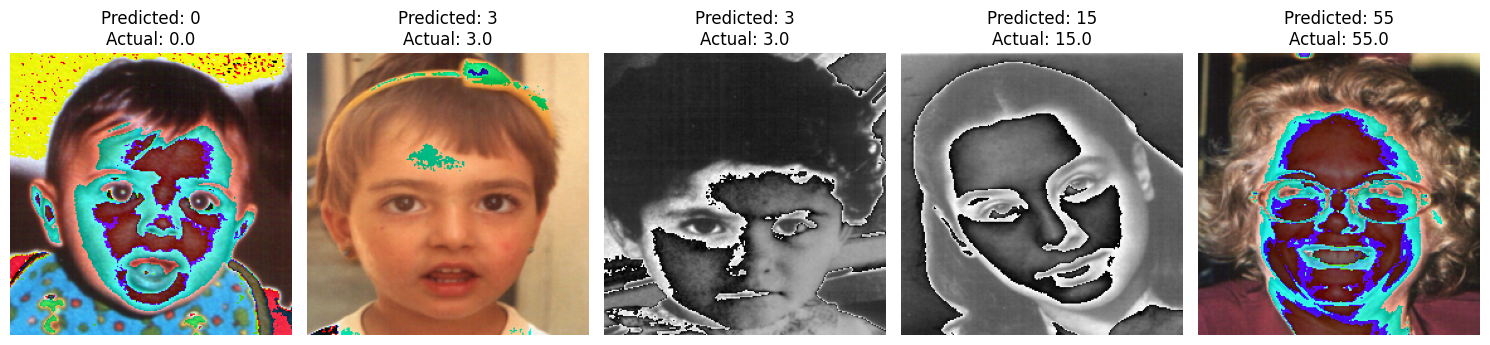

In [59]:
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torch
from torch.utils.data import DataLoader

def display_and_count_correct_predictions(model_anchor, regression_head, dataloader, device, max_images=5):
    """
    Display up to `max_images` images where the predicted age matches the actual age,
    and count the total number of correct predictions.

    Args:
        model_anchor (nn.Module): Trained anchor model.
        regression_head (nn.Module): Regression head for age prediction.
        dataloader (DataLoader): DataLoader for the evaluation dataset.
        device (torch.device): Device to run the predictions.
        max_images (int): Maximum number of correct images to display.

    Returns:
        int: Total number of correct predictions.
    """
    model_anchor.eval()
    regression_head.eval()

    correct_images = []
    total_correct = 0

    with torch.no_grad():
        for img_batch, actual_labels in dataloader:
            img_batch = img_batch.to(device)
            actual_labels = actual_labels.cpu().numpy()

            # Predict ages
            anchor_embeddings = model_anchor(img_batch)
            predicted_ages = regression_head(anchor_embeddings).squeeze(1).cpu().numpy()
            rounded_predictions = [int(round(age)) for age in predicted_ages]

            # Check correct predictions
            for idx, (predicted, actual) in enumerate(zip(rounded_predictions, actual_labels)):
                if predicted == actual:  # Correct prediction
                    total_correct += 1
                    if len(correct_images) < max_images:  # Collect up to max_images
                        correct_images.append((img_batch[idx].cpu(), predicted, actual))

    # Display the correct predictions
    if correct_images:
        plt.figure(figsize=(15, 10))
        for i, (img_tensor, predicted_age, actual_age) in enumerate(correct_images):
            img = transforms.ToPILImage()(img_tensor)  # Convert tensor to image
            plt.subplot(1, len(correct_images), i + 1)
            plt.imshow(img)
            plt.title(f"Predicted: {predicted_age}\nActual: {actual_age}")
            plt.axis("off")
        plt.tight_layout()
        plt.show()
    else:
        print("No correct predictions.")

    return total_correct

# Transformations for preprocessing images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load the dataset
dataset = load_dataset("/kaggle/input/fgnet-dataset/FGNET/images", "/kaggle/working/annotations.txt")
dataloader = DataLoader(dataset, batch_size=8, shuffle=False)

# Assuming `model_anchor` and `regression_head` are already trained and available
total_correct = display_and_count_correct_predictions(model_anchor, regression_head, dataloader, device, max_images=5)
